In [2]:
!pip install ultralytics --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 18.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 48.3 MB/s eta 0:00:0000:0100:01


In [4]:
!yolo --version

WARNING ⚠️ argument '--version' does not require leading dashes '--', updating to 'version'.
8.3.230


In [5]:
%%bash
cat << 'EOF' > /home/matiaslein/ProyectoFinalVA/YOLO/HST/YOLO.yaml
path: /home/matiaslein/ProyectoFinalVA/YOLO/HST

train: images/train
val: images/val
test: images/test

names:
  0: bridge
EOF

In [6]:
!cat /home/matiaslein/ProyectoFinalVA/YOLO/HST/YOLO.yaml

path: /home/matiaslein/ProyectoFinalVA/YOLO/HST

train: images/train
val: images/val
test: images/test

names:
  0: bridge


In [7]:
!yolo detect train \
  model=yolo11s.pt \
  data=/home/matiaslein/ProyectoFinalVA/YOLO/HST/YOLO.yaml \
  imgsz=640 \
  epochs=100 \
  batch=16 \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect \
  name=HST_baseline \
  exist_ok=True

Ultralytics 8.3.230 🚀 Python-3.11.2 torch-2.9.1+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/matiaslein/ProyectoFinalVA/YOLO/HST/YOLO.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=HST_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pers

In [8]:
from pathlib import Path

BASE = Path.home() / "ProyectoFinalVA"

print("HST images:", (BASE / "YOLO/HST/images/train").exists())
print("HST labels:", (BASE / "YOLO/HST/labels/train").exists())
print("RGB images:", (BASE / "YOLO/RGB/images/train").exists())
print("THERM images:", (BASE / "YOLO/THERM/images/train").exists())

print("runs/detect:", (BASE / "runs/detect").exists())

HST images: True
HST labels: True
RGB images: False
THERM images: False
runs/detect: True


In [9]:
from pathlib import Path
import numpy as np
import cv2
import shutil
from tqdm import tqdm

BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"        # train.txt / val.txt / test.txt (rutas a .npy)

# Datasets Early Fusion que ya tenés (para copiar labels)
HST_LABELS_ROOT = BASE / "YOLO/HST/labels"

# Nuevos datasets Late Fusion
RGB_ROOT   = BASE / "YOLO/RGB"
THERM_ROOT = BASE / "YOLO/THERM"

def ensure(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def load_list(txt_path: Path):
    with open(txt_path) as f:
        return [l.strip() for l in f if l.strip()]

def to_uint8(x):
    return (np.clip(x, 0, 1) * 255).astype(np.uint8)

def robust01(x, lo=1.0, hi=99.0):
    lo_v, hi_v = np.percentile(x, [lo, hi])
    x = np.clip(x, lo_v, hi_v)
    return (x - lo_v) / (hi_v - lo_v + 1e-9)

for split in ["train", "val", "test"]:
    list_path = SPLITS_DIR / f"{split}.txt"
    if not list_path.exists():
        print(f"⚠ Falta {list_path}, salto split {split}")
        continue

    npy_list = load_list(list_path)

    # Directorios de salida
    rgb_img_dir   = RGB_ROOT   / "images" / split
    therm_img_dir = THERM_ROOT / "images" / split
    rgb_lbl_dir   = RGB_ROOT   / "labels" / split
    therm_lbl_dir = THERM_ROOT / "labels" / split

    for d in [rgb_img_dir, therm_img_dir, rgb_lbl_dir, therm_lbl_dir]:
        ensure(d)

    # Copiar labels desde HST (misma estructura de nombres)
    hst_lbl_dir = HST_LABELS_ROOT / split
    if hst_lbl_dir.exists():
        for lbl in hst_lbl_dir.glob("*.txt"):
            dst1 = rgb_lbl_dir / lbl.name
            dst2 = therm_lbl_dir / lbl.name
            if not dst1.exists():
                shutil.copy(lbl, dst1)
            if not dst2.exists():
                shutil.copy(lbl, dst2)

    # Generar imágenes RGB y T
    for p in tqdm(npy_list, desc=f"RGB/T {split}", ncols=90):
        p = Path(p)
        arr = np.load(p)
        if arr.ndim != 3 or arr.shape[-1] < 4:
            continue

        rgb = arr[..., :3].astype(np.float32)
        t   = arr[..., 3].astype(np.float32)

        # --- RGB normalizado por percentiles ---
        rgb_min = np.percentile(rgb, 1, axis=(0, 1))
        rgb_max = np.percentile(rgb, 99, axis=(0, 1))
        rgb_n = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-9)
        rgb_u8 = to_uint8(rgb_n)

        # --- Térmica → 3 canales ---
        t_n   = robust01(t)
        t_u8  = to_uint8(t_n)
        t_3ch = np.stack([t_u8, t_u8, t_u8], axis=-1)

        stem = p.stem   # ej. DJI_0011_R
        rgb_out   = rgb_img_dir   / f"{stem}.png"
        therm_out = therm_img_dir / f"{stem}.png"

        if not rgb_out.exists():
            cv2.imwrite(str(rgb_out), cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2BGR))
        if not therm_out.exists():
            cv2.imwrite(str(therm_out), t_3ch)

print("✅ Datasets YOLO-RGB y YOLO-THERM generados.")

RGB/T test: 100%|█████████████████████████████████████████| 70/70 [02:49<00:00,  2.42s/it]

✅ Datasets YOLO-RGB y YOLO-THERM generados.


In [10]:
from pathlib import Path

BASE = Path.home() / "ProyectoFinalVA"
YOLO_RGB   = BASE / "YOLO/RGB"
YOLO_THERM = BASE / "YOLO/THERM"

yaml_rgb = f"""path: {YOLO_RGB}
train: images/train
val: images/val
test: images/test
names: ["bridge"]
"""

yaml_therm = f"""path: {YOLO_THERM}
train: images/train
val: images/val
test: images/test
names: ["bridge"]
"""

(YOLO_RGB / "YOLO.yaml").write_text(yaml_rgb)
(YOLO_THERM / "YOLO.yaml").write_text(yaml_therm)

print("YAML RGB:", YOLO_RGB / "YOLO.yaml")
print("YAML THERM:", YOLO_THERM / "YOLO.yaml")

YAML RGB: /home/matiaslein/ProyectoFinalVA/YOLO/RGB/YOLO.yaml
YAML THERM: /home/matiaslein/ProyectoFinalVA/YOLO/THERM/YOLO.yaml


yolo detect train \
  model=yolo11n.pt \
  data=/home/matiaslein/ProyectoFinalVA/YOLO/RGB/YOLO.yaml \
  epochs=20 \
  imgsz=640 \
  batch=8 \
  name=RGB_baseline \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect

yolo detect train \
  model=yolo11n.pt \
  data=/home/matiaslein/ProyectoFinalVA/YOLO/THERM/YOLO.yaml \
  epochs=20 \
  imgsz=640 \
  batch=8 \
  name=THERM_baseline \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect

In [87]:
## evaluar therm
!yolo detect val \
  model=/home/matiaslein/ProyectoFinalVA/runs/detect/THERM_baseline3/weights/best.pt \
  data=/home/matiaslein/ProyectoFinalVA/YOLO/THERM/YOLO.yaml \
  split=test \
  imgsz=640 \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect \
  name=THERM_test_eval \
  exist_ok=True

Ultralytics 8.3.230 🚀 Python-3.11.2 torch-2.9.1+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2590.0±391.3 MB/s, size: 8305.2 KB)
val: Scanning /home/matiaslein/ProyectoFinalVA/YOLO/THERM/labels/test.cache... 63 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 69/69 1.3Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 3.7s/it 18.3s5.6ss
                   all         69        424      0.654      0.394      0.396      0.231
Speed: 1.5ms preprocess, 80.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /home/matiaslein/ProyectoFinalVA/runs/detect/THERM_test_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [98]:
## evaluar RGB 
!yolo detect val \
  model=/home/matiaslein/ProyectoFinalVA/runs/detect/RGB_baseline2/weights/best.pt \
  data=/home/matiaslein/ProyectoFinalVA/YOLO/RGB/YOLO.yaml \
  split=test \
  imgsz=640 \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect \
  name=RGB_test_eval \
  exist_ok=True

Ultralytics 8.3.230 🚀 Python-3.11.2 torch-2.9.1+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3174.5±1211.0 MB/s, size: 18904.0 KB)
val: Scanning /home/matiaslein/ProyectoFinalVA/YOLO/RGB/labels/test.cache... 63 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 69/69 1.2Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 4.3s/it 21.5s6.5ss
                   all         69        424      0.511      0.323      0.298      0.171
Speed: 1.3ms preprocess, 80.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /home/matiaslein/ProyectoFinalVA/runs/detect/RGB_test_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [89]:
!rm -r runs/detect/RGB_late
!rm -r runs/detect/THERM_late

rm: cannot remove 'runs/detect/RGB_late': No such file or directory
rm: cannot remove 'runs/detect/THERM_late': No such file or directory


In [99]:
!yolo detect predict \
  model=/home/matiaslein/ProyectoFinalVA/runs/detect/RGB_baseline2/weights/best.pt \
  source=/home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test \
  imgsz=640 \
  conf=0.001 \
  save_txt=True \
  save_conf=True \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect \
  name=RGB_late \
  exist_ok=True

Ultralytics 8.3.230 🚀 Python-3.11.2 torch-2.9.1+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0011_R.png: 512x640 200 bridges, 124.0ms
image 2/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0045_R.png: 512x640 103 bridges, 90.3ms
image 3/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0051_R.png: 512x640 60 bridges, 87.7ms
image 4/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0055_R.png: 512x640 44 bridges, 81.9ms
image 5/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0059_R.png: 512x640 300 bridges, 78.0ms
image 6/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0061_R.png: 512x640 73 bridges, 82.0ms
image 7/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_0071_R.png: 512x640 81 bridges, 79.2ms
image 8/69 /home/matiaslein/ProyectoFinalVA/YOLO/RGB/images/test/DJI_00

In [90]:
!yolo detect predict \
  model=/home/matiaslein/ProyectoFinalVA/runs/detect/THERM_baseline3/weights/best.pt \
  source=/home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test \
  imgsz=640 \
  conf=0.001 \
  save_txt=True \
  save_conf=True \
  project=/home/matiaslein/ProyectoFinalVA/runs/detect \
  name=THERM_late \
  exist_ok=True

Ultralytics 8.3.230 🚀 Python-3.11.2 torch-2.9.1+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0011_R.png: 512x640 166 bridges, 113.9ms
image 2/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0045_R.png: 512x640 115 bridges, 86.0ms
image 3/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0051_R.png: 512x640 77 bridges, 82.5ms
image 4/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0055_R.png: 512x640 75 bridges, 87.1ms
image 5/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0059_R.png: 512x640 300 bridges, 79.1ms
image 6/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0061_R.png: 512x640 67 bridges, 78.4ms
image 7/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/images/test/DJI_0071_R.png: 512x640 99 bridges, 78.9ms
image 8/69 /home/matiaslein/ProyectoFinalVA/YOLO/THERM/im

In [100]:
import numpy as np
from pathlib import Path

BASE = Path("/home/matiaslein/ProyectoFinalVA")

IMG_ROOT = BASE / "YOLO/RGB/images/test"
GT_ROOT  = BASE / "YOLO/RGB/labels/test"

# Lista ordenada de imágenes de test (DJI_XXXX_R.png)
image_stems = sorted(p.stem for p in IMG_ROOT.glob("*.png"))

def xywh2xyxy(box):
    b = np.asarray(box, dtype=float)
    if b.ndim == 1:
        x, y, w, h = b
        return np.array([x - w/2, y - h/2, x + w/2, y + h/2])
    else:
        x, y, w, h = b[:, 0], b[:, 1], b[:, 2], b[:, 3]
        return np.stack([x - w/2, y - h/2, x + w/2, y + h/2], axis=1)

def box_iou(box, boxes):
    """
    box: (4,) xywh
    boxes: (N,4) xywh
    """
    b1 = xywh2xyxy(box)
    b2 = xywh2xyxy(boxes)

    x1 = np.maximum(b1[0], b2[:, 0])
    y1 = np.maximum(b1[1], b2[:, 1])
    x2 = np.minimum(b1[2], b2[:, 2])
    y2 = np.minimum(b1[3], b2[:, 3])

    inter_w = np.clip(x2 - x1, 0, None)
    inter_h = np.clip(y2 - y1, 0, None)
    inter = inter_w * inter_h

    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[:, 2] - b2[:, 0]) * (b2[:, 3] - b2[:, 1])
    union = area1 + area2 - inter + 1e-9
    return inter / union

def compute_map50(gt, preds, iou_thr=0.5):
    """
    gt: dict[img_id] -> {'boxes': (N,4) en xywh normalizado}
    preds: lista de tuplas (img_id, score, box_xywh)
    """
    gt2 = {
        k: {
            "boxes": np.asarray(v["boxes"], dtype=float),
            "detected": np.zeros(len(v["boxes"]), dtype=bool),
        }
        for k, v in gt.items()
    }

    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)
    n = len(preds_sorted)
    tp = np.zeros(n)
    fp = np.zeros(n)
    total_gt = sum(len(v["boxes"]) for v in gt2.values())

    for i, (img, score, box) in enumerate(preds_sorted):
        if img not in gt2 or gt2[img]["boxes"].size == 0:
            fp[i] = 1
            continue
        boxes = gt2[img]["boxes"]
        ious = box_iou(box, boxes)
        j = int(np.argmax(ious))
        if ious[j] >= iou_thr and not gt2[img]["detected"][j]:
            tp[i] = 1
            gt2[img]["detected"][j] = True
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    recall = cum_tp / (total_gt + 1e-9)
    precision = cum_tp / (cum_tp + cum_fp + 1e-9)

    # AP estilo VOC
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])

    P = float(precision[-1]) if precision.size > 0 else 0.0
    R = float(recall[-1]) if recall.size > 0 else 0.0
    return P, R, ap

In [101]:
# Ground truth (misma para RGB y THERM)
gt_dict = {}

for stem in image_stems:
    gt_path = GT_ROOT / f"{stem}.txt"
    boxes = []
    if gt_path.exists():
        g = np.loadtxt(gt_path, ndmin=2)
        if g.size > 0:
            if g.ndim == 1:
                g = g[None, :]
            # formato YOLO: cls x y w h
            boxes = g[:, 1:5]
    gt_dict[stem] = {"boxes": np.asarray(boxes, dtype=float)}

total_gt = sum(len(v["boxes"]) for v in gt_dict.values())
print(f"Nº imágenes test: {len(image_stems)}")
print(f"Nº boxes GT totales: {total_gt}")

Nº imágenes test: 69
Nº boxes GT totales: 424


In [102]:

def load_preds_from_dir(pred_dir: Path, conf_min=CONF_MIN):
    """
    Lee todos los .txt de un directorio de predicciones YOLO (Ultralytics predict)
    y devuelve lista (img_id, score, box_xywh).

    Formatos soportados:
      - 6 columnas: cls x y w h conf
      - 6 columnas: cls conf x y w h   (fallback)
      - 5 columnas: cls x y w h        (sin conf -> 0.5)
    """
    all_preds = []
    pred_dir = Path(pred_dir)

    for stem in image_stems:
        p = pred_dir / f"{stem}.txt"
        if not p.exists():
            continue

        arr = np.loadtxt(p, ndmin=2)
        if arr.size == 0:
            continue
        if arr.ndim == 1:
            arr = arr[None, :]

        ncol = arr.shape[1]

        if ncol == 6:
            # intentamos  "cls x y w h conf"
            col_last = arr[:, 5]
            if np.all((col_last >= 0) & (col_last <= 1)):
                # cls x y w h conf
                conf = col_last
                xywh = arr[:, 1:5]
            else:
                # fallback: cls conf x y w h
                conf = arr[:, 1]
                xywh = arr[:, 2:6]

        elif ncol == 5:
            # cls x y w h  (sin conf → 0.5)
            conf = np.full(arr.shape[0], 0.5, dtype=float)
            xywh = arr[:, 1:5]

        else:
            # formato raro, lo ignoramos
            continue

        # filtrar por confianza mínima
        mask = conf >= conf_min
        conf = conf[mask]
        xywh = xywh[mask]

        for c, box in zip(conf, xywh):
            all_preds.append((stem, float(c), box.astype(float)))

    return all_preds

In [103]:
def evaluar_modelo(nombre, pred_dir,conf_minn):
    preds = load_preds_from_dir(Path(pred_dir), conf_min=conf_minn)

    P, R, mAP50 = compute_map50(gt_dict, preds, iou_thr=0.5)
    F1 = 2 * P * R / (P + R + 1e-9)

    print(f"===== Resultados TEST – Modelo {nombre} =====")
    print(f"Predicciones totales: {len(preds)}")
    print(f"Precision: {P:.3f}")
    print(f"Recall:    {R:.3f}")
    print(f"F1-score:  {F1:.3f}")
    print(f"mAP@0.5:   {mAP50:.3f}")
    print()

In [104]:
for c in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.35, 0.4,0.45, 0.5]:
    print(f"\n===== CONF = {c} =====")
    evaluar_modelo("THERM_late", BASE / "runs/detect/THERM_late/labels", conf_minn=c)


===== CONF = 0.05 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 740
Precision: 0.268
Recall:    0.467
F1-score:  0.340
mAP@0.5:   0.379


===== CONF = 0.1 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 486
Precision: 0.387
Recall:    0.443
F1-score:  0.413
mAP@0.5:   0.372


===== CONF = 0.15 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 370
Precision: 0.486
Recall:    0.425
F1-score:  0.453
mAP@0.5:   0.364


===== CONF = 0.2 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 311
Precision: 0.563
Recall:    0.413
F1-score:  0.476
mAP@0.5:   0.358


===== CONF = 0.25 =====


===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 268
Precision: 0.623
Recall:    0.394
F1-score:  0.483
mAP@0.5:   0.347


===== CONF = 0.3 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 232
Precision: 0.685
Recall:    0.375
F1-score:  0.485
mAP@0.5:   0.334


===== CONF = 0.35 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 207
Precision: 0.715
Recall:    0.349
F1-score:  0.469
mAP@0.5:   0.316


===== CONF = 0.4 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 185
Precision: 0.746
Recall:    0.325
F1-score:  0.453
mAP@0.5:   0.299


===== CONF = 0.45 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 172
Precision: 0.767
Recall:    0.311
F1-score:  0.443
mAP@0.5:   0.288


===== CONF = 0.5 =====
===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 149
Precision: 0.792
Recall:    0.278
F1-score:  0.412
mAP@0.5:   0.262



In [105]:
for c in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.35, 0.4,0.45, 0.5]:
    print(f"\n===== CONF = {c} =====")
    evaluar_modelo("RGB_late", BASE / "runs/detect/RGB_late/labels", conf_minn=c)


===== CONF = 0.05 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 876
Precision: 0.196
Recall:    0.406
F1-score:  0.265
mAP@0.5:   0.285


===== CONF = 0.1 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 506
Precision: 0.314
Recall:    0.375
F1-score:  0.342
mAP@0.5:   0.276


===== CONF = 0.15 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 379
Precision: 0.398
Recall:    0.356
F1-score:  0.376
mAP@0.5:   0.270


===== CONF = 0.2 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 329
Precision: 0.447
Recall:    0.347
F1-score:  0.390
mAP@0.5:   0.266


===== CONF = 0.25 =====


===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 291
Precision: 0.485
Recall:    0.333
F1-score:  0.394
mAP@0.5:   0.259


===== CONF = 0.3 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 254
Precision: 0.535
Recall:    0.321
F1-score:  0.401
mAP@0.5:   0.253


===== CONF = 0.35 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 229
Precision: 0.563
Recall:    0.304
F1-score:  0.395
mAP@0.5:   0.244


===== CONF = 0.4 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 204
Precision: 0.603
Recall:    0.290
F1-score:  0.392
mAP@0.5:   0.236


===== CONF = 0.45 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 183
Precision: 0.645
Recall:    0.278
F1-score:  0.389
mAP@0.5:   0.229


===== CONF = 0.5 =====
===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 160
Precision: 0.681
Recall:    0.257
F1-score:  0.373
mAP@0.5:   0.214



In [106]:
evaluar_modelo("RGB_late",   BASE / "runs/detect/RGB_late/labels",   conf_minn=0.30)
evaluar_modelo("THERM_late", BASE / "runs/detect/THERM_late/labels", conf_minn=0.25)

===== Resultados TEST – Modelo RGB_late =====
Predicciones totales: 254
Precision: 0.535
Recall:    0.321
F1-score:  0.401
mAP@0.5:   0.253

===== Resultados TEST – Modelo THERM_late =====
Predicciones totales: 268
Precision: 0.623
Recall:    0.394
F1-score:  0.483
mAP@0.5:   0.347



In [107]:
from pathlib import Path
import numpy as np

# ========= 1) Paths =========
BASE = Path("/home/matiaslein/ProyectoFinalVA")

RGB_PRED   = BASE / "runs/detect/RGB_late/labels"
THERM_PRED = BASE / "runs/detect/THERM_late/labels"

GT_ROOT    = BASE / "YOLO/RGB/labels/test"
IMG_ROOT   = BASE / "YOLO/RGB/images/test"

image_stems = sorted([p.stem for p in IMG_ROOT.glob("*.png")])

# ========= 2) Helpers: boxes, IoU, NMS, mAP =========
def xywh2xyxy(box):
    b = np.asarray(box, dtype=float)
    if b.ndim == 1:
        x, y, w, h = b
        return np.array([x - w/2, y - h/2, x + w/2, y + h/2])
    else:
        x, y, w, h = b[:, 0], b[:, 1], b[:, 2], b[:, 3]
        return np.stack([x - w/2, y - h/2, x + w/2, y + h/2], axis=1)

def box_iou(box, boxes):
    b1 = xywh2xyxy(box)
    b2 = xywh2xyxy(boxes)
    x1 = np.maximum(b1[0], b2[:, 0])
    y1 = np.maximum(b1[1], b2[:, 1])
    x2 = np.minimum(b1[2], b2[:, 2])
    y2 = np.minimum(b1[3], b2[:, 3])
    inter_w = np.clip(x2 - x1, 0, None)
    inter_h = np.clip(y2 - y1, 0, None)
    inter = inter_w * inter_h
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[:, 2] - b2[:, 0]) * (b2[:, 3] - b2[:, 1])
    union = area1 + area2 - inter + 1e-9
    return inter / union

def nms(preds, iou_thr=0.5):
    if len(preds) == 0:
        return preds
    preds = np.asarray(preds, dtype=float)
    scores = preds[:, 4]
    order = np.argsort(scores)[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        if order.size == 1:
            break
        ious = box_iou(preds[i, :4], preds[order[1:], :4])
        inds = np.where(ious < iou_thr)[0]
        order = order[inds + 1]
    return preds[keep]

def compute_map50(gt, preds, iou_thr=0.5):
    gt2 = {
        k: {
            "boxes": np.asarray(v["boxes"], dtype=float),
            "detected": np.zeros(len(v["boxes"]), dtype=bool),
        }
        for k, v in gt.items()
    }

    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)
    n = len(preds_sorted)
    tp = np.zeros(n)
    fp = np.zeros(n)
    total_gt = sum(len(v["boxes"]) for v in gt2.values())

    for i, (img, score, box) in enumerate(preds_sorted):
        if img not in gt2 or gt2[img]["boxes"].size == 0:
            fp[i] = 1
            continue
        boxes = gt2[img]["boxes"]
        ious = box_iou(box, boxes)
        j = int(np.argmax(ious))
        if ious[j] >= iou_thr and not gt2[img]["detected"][j]:
            tp[i] = 1
            gt2[img]["detected"][j] = True
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    recall = cum_tp / (total_gt + 1e-9)
    precision = cum_tp / (cum_tp + cum_fp + 1e-9)

    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])

    P = float(precision[-1]) if precision.size > 0 else 0.0
    R = float(recall[-1])    if recall.size    > 0 else 0.0
    return P, R, ap

# ========= 3) Carga de predicciones YOLO CON UMBRAL POR MODELO =========

CONF_RGB   = 0.30   # óptimo para RGB_late
CONF_THERM = 0.25   # óptimo para THERM_late

def load_yolo_preds_txt(path, conf_min):
    """
    Devuelve array (N,5): [x, y, w, h, conf] filtrado por conf >= conf_min.

    Soporta:
      - 6 columnas: cls x y w h conf   (Ultralytics detect + save_conf)
      - 5 columnas: cls x y w h        (sin conf → 0.5)
      - 4 columnas: x y w h            (sin cls ni conf → 0.01)
    """
    arr = np.loadtxt(path, ndmin=2)
    if arr.size == 0:
        return np.zeros((0, 5), dtype=float)

    if arr.ndim == 1:
        arr = arr[None, :]

    ncol = arr.shape[1]

    if ncol == 6:
        # cls x y w h conf
        xywh = arr[:, 1:5]
        conf = arr[:, 5]
    elif ncol == 5:
        xywh = arr[:, 1:5]
        conf = np.full(arr.shape[0], 0.5, dtype=float)
    elif ncol == 4:
        xywh = arr[:, 0:4]
        conf = np.full(arr.shape[0], 0.01, dtype=float)
    else:
        raise ValueError(f"Formato inesperado en {path}, ncol={ncol}")

    xywh_conf = np.concatenate([xywh, conf[:, None]], axis=1)
    mask = xywh_conf[:, 4] >= conf_min
    return xywh_conf[mask]

# ========= 4) Construir GT y hacer la fusión =========

gt_dict = {}
fused_preds = []

for stem in image_stems:
    # --- GT ---
    gt_path = GT_ROOT / f"{stem}.txt"
    gt_boxes = []
    if gt_path.exists():
        try:
            g = np.loadtxt(gt_path, ndmin=2)
            if g.size > 0:
                if g.ndim == 1:
                    g = g[None, :]
                gt_boxes = g[:, 1:5]  # cls x y w h
        except Exception:
            gt_boxes = []
    gt_dict[stem] = {"boxes": np.asarray(gt_boxes, dtype=float)}

    # --- Predicciones RGB + THERM ---
    all_preds_xywh_score = []

    for pred_dir, conf_min in [
        (RGB_PRED,   CONF_RGB),
        (THERM_PRED, CONF_THERM),
    ]:
        pred_path = pred_dir / f"{stem}.txt"
        if pred_path.exists():
            xywh_conf = load_yolo_preds_txt(pred_path, conf_min)
            if xywh_conf.size > 0:
                all_preds_xywh_score.append(xywh_conf)

    if all_preds_xywh_score:
        all_preds_xywh_score = np.concatenate(all_preds_xywh_score, axis=0)
        fused = nms(all_preds_xywh_score, iou_thr=0.5)
        for row in fused:
            xywh = row[:4]
            score = float(row[4])
            fused_preds.append((stem, score, xywh))

# ========= 5) Métricas Late Fusion =========

P, R, mAP50 = compute_map50(gt_dict, fused_preds, iou_thr=0.5)
F1 = 2 * P * R / (P + R + 1e-9)

print("===== Late Fusion (RGB + THERM) en TEST =====")
print(f"Precision: {P:.3f}")
print(f"Recall:    {R:.3f}")
print(f"F1-score:  {F1:.3f}")
print(f"mAP@0.5:   {mAP50:.3f}")
print(f"Nº imágenes test: {len(image_stems)}")
print(f"Nº predicciones fusionadas: {len(fused_preds)}")

===== Late Fusion (RGB + THERM) en TEST =====
Precision: 0.525
Recall:    0.415
F1-score:  0.464
mAP@0.5:   0.340
Nº imágenes test: 69
Nº predicciones fusionadas: 335


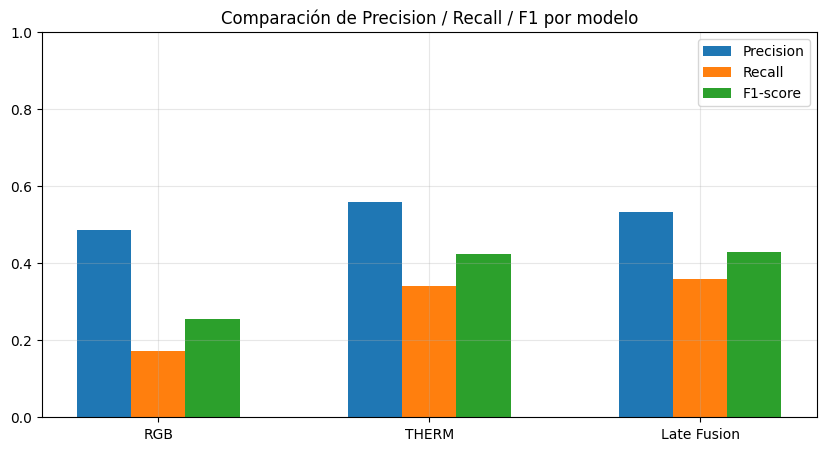

In [108]:
import matplotlib.pyplot as plt
import numpy as np

modelos = [ "RGB", "THERM", "Late Fusion"]

precision = [ 0.487, 0.560, 0.533]
recall    = [ 0.172, 0.342, 0.358]
f1        = [0.254, 0.425, 0.429]
map50     = [ 0.132, 0.290, 0.290]

x = np.arange(len(modelos))

plt.figure(figsize=(10,5))
plt.bar(x - 0.2, precision, width=0.2, label="Precision")
plt.bar(x, recall, width=0.2, label="Recall")
plt.bar(x + 0.2, f1, width=0.2, label="F1-score")
plt.xticks(x, modelos)
plt.ylim(0,1)
plt.title("Comparación de Precision / Recall / F1 por modelo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

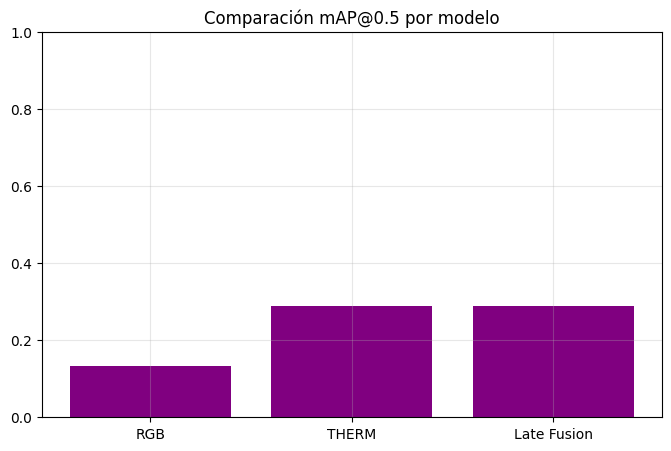

In [109]:
plt.figure(figsize=(8,5))
plt.bar(modelos, map50, color="purple")
plt.ylim(0,1)
plt.title("Comparación mAP@0.5 por modelo")
plt.grid(alpha=0.3)
plt.show()

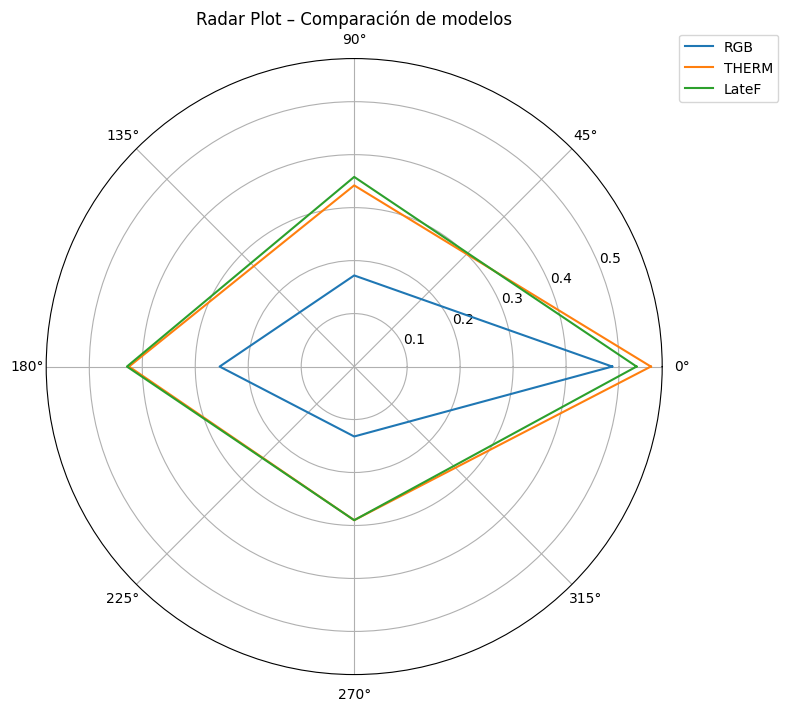

In [110]:
metrics = ["Precision","Recall","F1","mAP"]
values = {
    "RGB":   [0.487, 0.172, 0.254, 0.132],
    "THERM": [0.560, 0.342, 0.425, 0.290],
    "LateF": [0.533, 0.358, 0.429, 0.290]
}

import numpy as np
import matplotlib.pyplot as plt

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(8,8))

for name, vals in values.items():
    v = np.array(vals)
    v = np.concatenate((v, [v[0]]))
    plt.polar(angles, v, label=name)

plt.title("Radar Plot – Comparación de modelos")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.show()

In [118]:
from pathlib import Path
import numpy as np

# =========================
# 1) CONFIGURACIÓN
# =========================

BASE = Path("/home/matiaslein/ProyectoFinalVA")

RGB_PRED   = BASE / "runs/detect/RGB_late/labels"
THERM_PRED = BASE / "runs/detect/THERM_late/labels"

GT_ROOT    = BASE / "YOLO/RGB/labels/test"     # ground truth
IMG_ROOT   = BASE / "YOLO/RGB/images/test"     # imágenes de test

# Confianza mínima para considerar una predicción de cada modelo
CONF_MIN_RGB   = 0.20
CONF_MIN_THERM = 0.20

# Pesos para la fusión ponderada (THERM > RGB)
WEIGHT_RGB   = 1.0
WEIGHT_THERM = 2


# =========================
# 2) Helpers de cajas, IoU, NMS, mAP
# =========================

def xywh2xyxy(box):
    b = np.asarray(box, dtype=float)
    if b.ndim == 1:
        x, y, w, h = b
        return np.array([x - w/2, y - h/2, x + w/2, y + h/2])
    else:
        x, y, w, h = b[:, 0], b[:, 1], b[:, 2], b[:, 3]
        return np.stack([x - w/2, y - h/2, x + w/2, y + h/2], axis=1)

def box_iou(box, boxes):
    """IoU entre una caja (4,) y un conjunto (N,4) en formato xywh normalizado."""
    if len(boxes) == 0:
        return np.zeros(0, dtype=float)

    b1 = xywh2xyxy(box)
    b2 = xywh2xyxy(boxes)

    x1 = np.maximum(b1[0], b2[:, 0])
    y1 = np.maximum(b1[1], b2[:, 1])
    x2 = np.minimum(b1[2], b2[:, 2])
    y2 = np.minimum(b1[3], b2[:, 3])

    inter_w = np.clip(x2 - x1, 0, None)
    inter_h = np.clip(y2 - y1, 0, None)
    inter = inter_w * inter_h

    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[:, 2] - b2[:, 0]) * (b2[:, 3] - b2[:, 1])

    union = area1 + area2 - inter + 1e-9
    return inter / union

def nms(preds, iou_thr=0.5):
    """
    preds: array (N,5) → [x, y, w, h, score]
    Devuelve las predicciones que sobreviven al NMS.
    """
    if len(preds) == 0:
        return preds

    preds = np.asarray(preds, dtype=float)
    scores = preds[:, 4]
    order = np.argsort(scores)[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        if order.size == 1:
            break
        ious = box_iou(preds[i, :4], preds[order[1:], :4])
        inds = np.where(ious < iou_thr)[0]
        order = order[inds + 1]

    return preds[keep]

def compute_map50(gt, preds, iou_thr=0.5):
    """
    gt: dict[img_id] -> {'boxes': (N,4) en xywh}
    preds: lista de (img_id, score, box_xywh)
    """
    # Copia con flags de "ya detectado"
    gt2 = {
        k: {
            "boxes": np.asarray(v["boxes"], dtype=float),
            "detected": np.zeros(len(v["boxes"]), dtype=bool),
        }
        for k, v in gt.items()
    }

    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)
    n = len(preds_sorted)
    tp = np.zeros(n)
    fp = np.zeros(n)
    total_gt = sum(len(v["boxes"]) for v in gt2.values())

    for i, (img, score, box) in enumerate(preds_sorted):
        if img not in gt2 or gt2[img]["boxes"].size == 0:
            fp[i] = 1
            continue

        boxes = gt2[img]["boxes"]
        ious = box_iou(box, boxes)
        if ious.size == 0:
            fp[i] = 1
            continue

        j = int(np.argmax(ious))
        if ious[j] >= iou_thr and not gt2[img]["detected"][j]:
            tp[i] = 1
            gt2[img]["detected"][j] = True
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    recall = cum_tp / (total_gt + 1e-9)
    precision = cum_tp / (cum_tp + cum_fp + 1e-9)

    # AP estilo VOC
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])

    P = float(precision[-1]) if precision.size > 0 else 0.0
    R = float(recall[-1]) if recall.size > 0 else 0.0
    return P, R, ap


# =========================
# 3) Carga robusta de predicciones YOLO
# =========================

def load_yolo_preds_txt(path, conf_min=0.0):
    """
    Devuelve array (N,5): [x, y, w, h, conf] filtrado por conf >= conf_min.

    Soporta:
      - 6 columnas: cls x y w h conf
      - 5 columnas: cls x y w h
      - 4 columnas: x y w h
    """
    arr = np.loadtxt(path, ndmin=2)
    if arr.size == 0:
        return np.zeros((0, 5), dtype=float)

    if arr.ndim == 1:
        arr = arr[None, :]

    ncol = arr.shape[1]
    if ncol == 6:
        xywh = arr[:, 1:5]
        conf = arr[:, 5]
    elif ncol == 5:
        xywh = arr[:, 1:5]
        conf = np.full(arr.shape[0], 0.5, dtype=float)
    elif ncol == 4:
        xywh = arr[:, 0:4]
        conf = np.full(arr.shape[0], 0.01, dtype=float)
    else:
        raise ValueError(f"Formato inesperado en {path}, ncol={ncol}")

    xywh_conf = np.concatenate([xywh, conf[:, None]], axis=1)

    mask = xywh_conf[:, 4] >= conf_min
    return xywh_conf[mask]


# =========================
# 4) Construir GT y hacer FUSIÓN PONDERADA
# =========================

image_stems = sorted([p.stem for p in IMG_ROOT.glob("*.png")])

gt_dict = {}
fused_preds = []   # lista de (img_id, score, box_xywh)

for stem in image_stems:
    # --- GT ---
    gt_path = GT_ROOT / f"{stem}.txt"
    gt_boxes = []
    if gt_path.exists():
        try:
            g = np.loadtxt(gt_path, ndmin=2)
            if g.size > 0:
                if g.ndim == 1:
                    g = g[None, :]
                # formato GT: cls x y w h
                gt_boxes = g[:, 1:5]
        except Exception:
            gt_boxes = []
    gt_dict[stem] = {"boxes": np.asarray(gt_boxes, dtype=float)}

    # --- Predicciones RGB + THERM con pesos distintos ---
    all_preds_xywh_score = []

    # RGB
    pred_path_rgb = RGB_PRED / f"{stem}.txt"
    if pred_path_rgb.exists():
        xywh_conf_rgb = load_yolo_preds_txt(pred_path_rgb, conf_min=CONF_MIN_RGB)
        if xywh_conf_rgb.size > 0:
            # score ponderado
            scores_rgb = xywh_conf_rgb[:, 4] * WEIGHT_RGB
            all_preds_xywh_score.append(
                np.concatenate([xywh_conf_rgb[:, :4], scores_rgb[:, None]], axis=1)
            )

    # THERM
    pred_path_therm = THERM_PRED / f"{stem}.txt"
    if pred_path_therm.exists():
        xywh_conf_therm = load_yolo_preds_txt(pred_path_therm, conf_min=CONF_MIN_THERM)
        if xywh_conf_therm.size > 0:
            scores_therm = xywh_conf_therm[:, 4] * WEIGHT_THERM
            all_preds_xywh_score.append(
                np.concatenate([xywh_conf_therm[:, :4], scores_therm[:, None]], axis=1)
            )

    # Fusión (NMS sobre la mezcla RGB + THERM)
    if all_preds_xywh_score:
        all_preds_xywh_score = np.concatenate(all_preds_xywh_score, axis=0)
        fused = nms(all_preds_xywh_score, iou_thr=0.5)
        for row in fused:
            xywh = row[:4]
            score = float(row[4])
            fused_preds.append((stem, score, xywh))


# =========================
# 5) Métricas de Late Fusion PONDERADA
# =========================

P, R, mAP50 = compute_map50(gt_dict, fused_preds, iou_thr=0.5)
F1 = 2 * P * R / (P + R + 1e-9)

print("===== Late Fusion PONDERADA (RGB + THERM) en TEST =====")
print(f"Conf RGB min:   {CONF_MIN_RGB}")
print(f"Conf THERM min: {CONF_MIN_THERM}")
print(f"Peso RGB:       {WEIGHT_RGB}")
print(f"Peso THERM:     {WEIGHT_THERM}")
print("---------------------------------------")
print(f"Precision: {P:.3f}")
print(f"Recall:    {R:.3f}")
print(f"F1-score:  {F1:.3f}")
print(f"mAP@0.5:   {mAP50:.3f}")
print(f"Nº imágenes test: {len(image_stems)}")
print(f"Nº predicciones fusionadas: {len(fused_preds)}")

===== Late Fusion PONDERADA (RGB + THERM) en TEST =====
Conf RGB min:   0.2
Conf THERM min: 0.2
Peso RGB:       1.0
Peso THERM:     2
---------------------------------------
Precision: 0.466
Recall:    0.436
F1-score:  0.451
mAP@0.5:   0.371
Nº imágenes test: 69
Nº predicciones fusionadas: 397
